In [ ]:
!pip install pyspark
!pip install findspark

In [ ]:
#very important, has to run
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz

In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,032 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
G

In [ ]:
import os
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-8-openjdk-amd64'
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"
!ls

sample_data  spark-3.5.0-bin-hadoop3  spark-3.5.0-bin-hadoop3.tgz


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing required libraries
import warnings
warnings.filterwarnings('ignore')

# Visualization and text handling libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter

# Importing Spark libraries
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, concat_ws, length, split, avg, count
from pyspark.ml.feature import CountVectorizer, Tokenizer, StringIndexer
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.functions import size
from pyspark.ml.feature import NGram


In [ ]:
# Initialize Spark session
import pyspark
from pyspark.sql.functions import *
import findspark
from pyspark.sql import SparkSession
findspark.init()
spark = SparkSession.builder.master("local[*]").appName("AmazonReviewsAnalysis").getOrCreate()
spark.conf.set("spark.sql.repl.eagerEval.enabled", True) #to format tables better
spark

In [ ]:
# Load dataset
reviews = spark.read.csv('/content/drive/MyDrive/dataset/train.csv', header=False, inferSchema=True)
reviews = reviews.withColumnRenamed("_c0", "ratings").withColumnRenamed("_c1", "title").withColumnRenamed("_c2", "review")


In [ ]:

# Display initial dataset info
reviews.show(5)

+-------+--------------------+--------------------+
|ratings|               title|              review|
+-------+--------------------+--------------------+
|      2|Stuning even for ...|This sound track ...|
|      2|The best soundtra...|I'm reading a lot...|
|      2|            Amazing!|"This soundtrack ...|
|      2|Excellent Soundtrack|I truly like this...|
|      2|Remember, Pull Yo...|If you've played ...|
+-------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
reviews.describe().show()

+-------+------------------+--------------------+--------------------+
|summary|           ratings|               title|              review|
+-------+------------------+--------------------+--------------------+
|  count|           3600000|             3599952|             3599987|
|   mean|               1.5|                 NaN|                NULL|
| stddev|0.5000000694444585|                 NaN|                NULL|
|    min|                 1|The Worst Thing ...|this is the best...|
|    max|                 2|         ♦ LOVE IT ♦|…were Marvin and ...|
+-------+------------------+--------------------+--------------------+



In [ ]:
# Group by ratings
reviews.groupBy("ratings").count().show()

+-------+-------+
|ratings|  count|
+-------+-------+
|      1|1800000|
|      2|1800000|
+-------+-------+



In [ ]:

# Systematic sampling function
def systematic_sampling(df, step):
    return df.rdd.zipWithIndex().filter(lambda x: x[1] % step == 0).map(lambda x: x[0]).toDF(df.columns)

reviews_subset = systematic_sampling(reviews, 100)
reviews_subset.groupBy('ratings').count().show()

+-------+-----+
|ratings|count|
+-------+-----+
|      1|17782|
|      2|18218|
+-------+-----+



In [ ]:
# Reset index (in Spark, add temp column)
reviews_subset = reviews_subset.withColumn("id", col("ratings"))

# Create sentiment column based on ratings
reviews_subset = reviews_subset.withColumn("sentiment",
                                           pyspark.sql.functions.when(col("ratings") == 2, "positive").otherwise("negative"))

In [ ]:
# Combine title and review columns
reviews_subset = reviews_subset.withColumn("review", concat_ws(" ", col("title"), col("review")))

# Drop unnecessary columns
reviews_subset = reviews_subset.drop("title", "ratings")

# Drop null values
reviews_subset = reviews_subset.dropna()

# Check for missing values
reviews_subset.select([count(when(col(c).isNull(), c)).alias(c) for c in reviews_subset.columns]).show()
# Print schema
reviews_subset.printSchema()

# Display unique sentiment values
reviews_subset.select("sentiment").distinct().show()

reviews_subset.show(5)

+------+---+---------+
|review| id|sentiment|
+------+---+---------+
|     0|  0|        0|
+------+---+---------+

root
 |-- review: string (nullable = false)
 |-- id: long (nullable = true)
 |-- sentiment: string (nullable = false)

+---------+
|sentiment|
+---------+
| positive|
| negative|
+---------+

+--------------------+---+---------+
|              review| id|sentiment|
+--------------------+---+---------+
|Stuning even for ...|  2| positive|
|textbook Book shi...|  2| positive|
|Worthless and che...|  1| negative|
|super wack just l...|  1| negative|
|Starts out with p...|  1| negative|
+--------------------+---+---------+
only showing top 5 rows



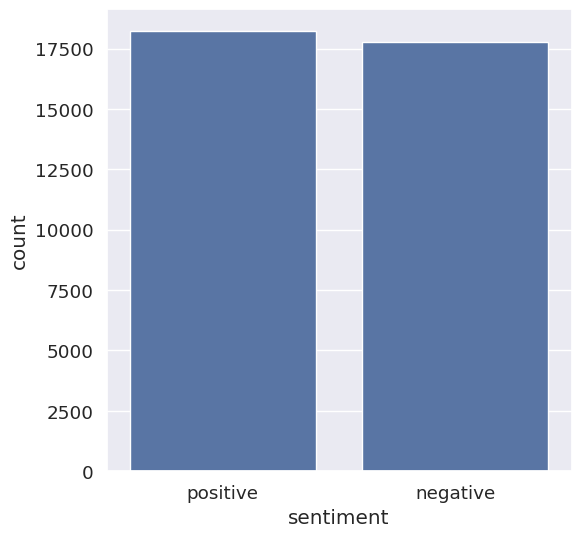

In [ ]:
# Visualize sentiment distribution
sns.set(style="darkgrid", font_scale=1.2)
plt.figure(figsize=(6,6))
sns.countplot(x='sentiment', data=reviews_subset.toPandas())
plt.show()

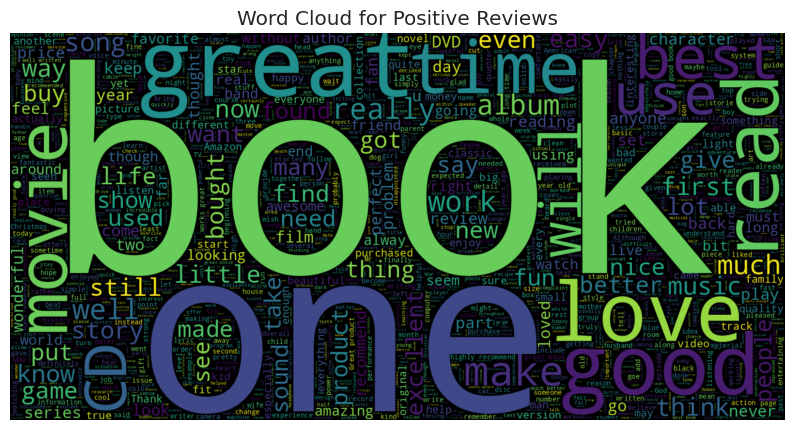

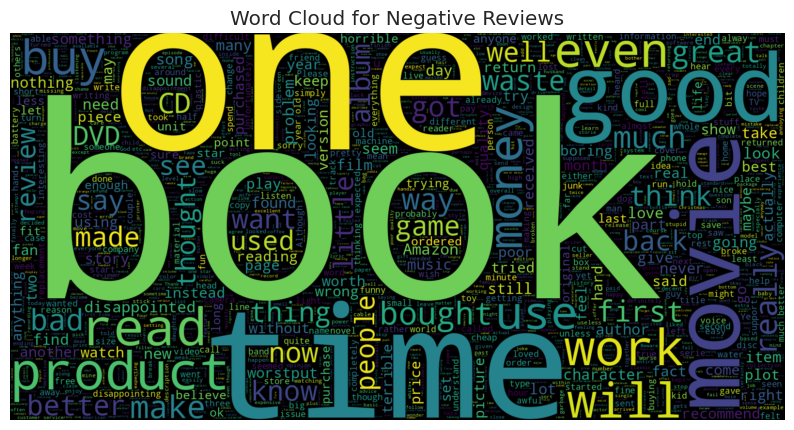

In [ ]:
# Replace sentiment labels with numeric values
indexer = StringIndexer(inputCol="sentiment", outputCol="label")
reviews_subset = indexer.fit(reviews_subset).transform(reviews_subset)

# Generate WordCloud for positive reviews
positive_reviews = " ".join(reviews_subset.filter(col("sentiment") == "positive").select("review").rdd.flatMap(lambda x: x).collect())
plt.figure(figsize=(10,10))
wc = WordCloud(max_words=2000, width=1600, height=800).generate(positive_reviews)
plt.imshow(wc, interpolation='bilinear')
plt.title('Word Cloud for Positive Reviews')
plt.axis("off")
plt.show()

# Generate WordCloud for negative reviews
negative_reviews = " ".join(reviews_subset.filter(col("sentiment") == "negative").select("review").rdd.flatMap(lambda x: x).collect())
plt.figure(figsize=(10,10))
wc = WordCloud(max_words=2000, width=1600, height=800).generate(negative_reviews)
plt.imshow(wc, interpolation='bilinear')
plt.title('Word Cloud for Negative Reviews')
plt.axis("off")
plt.show()

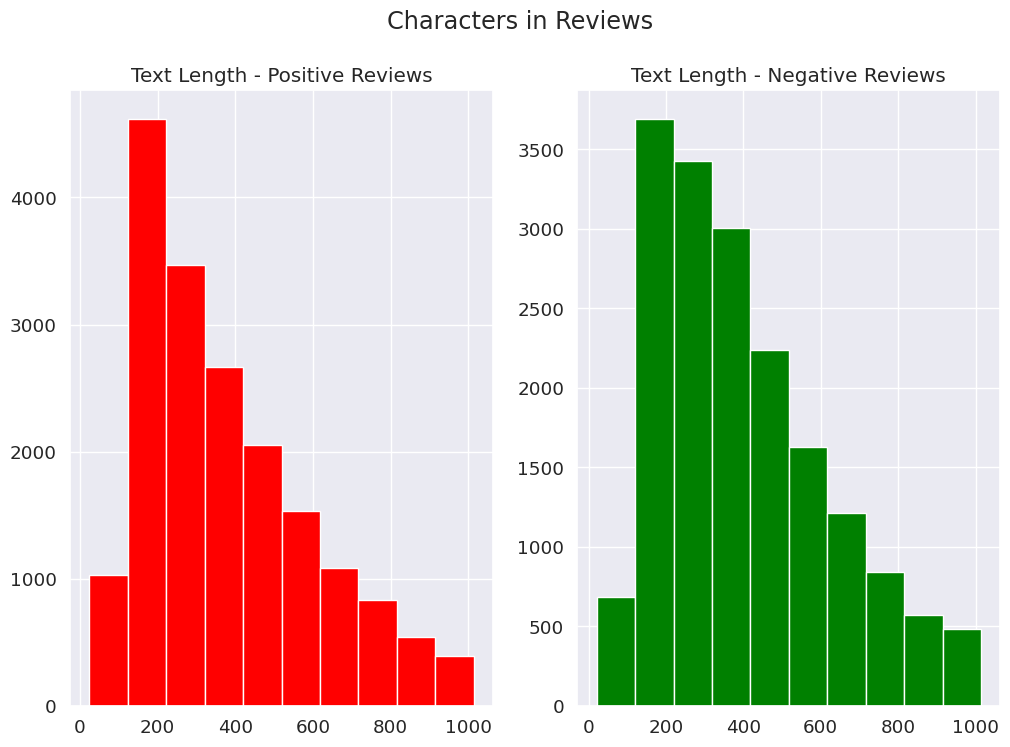

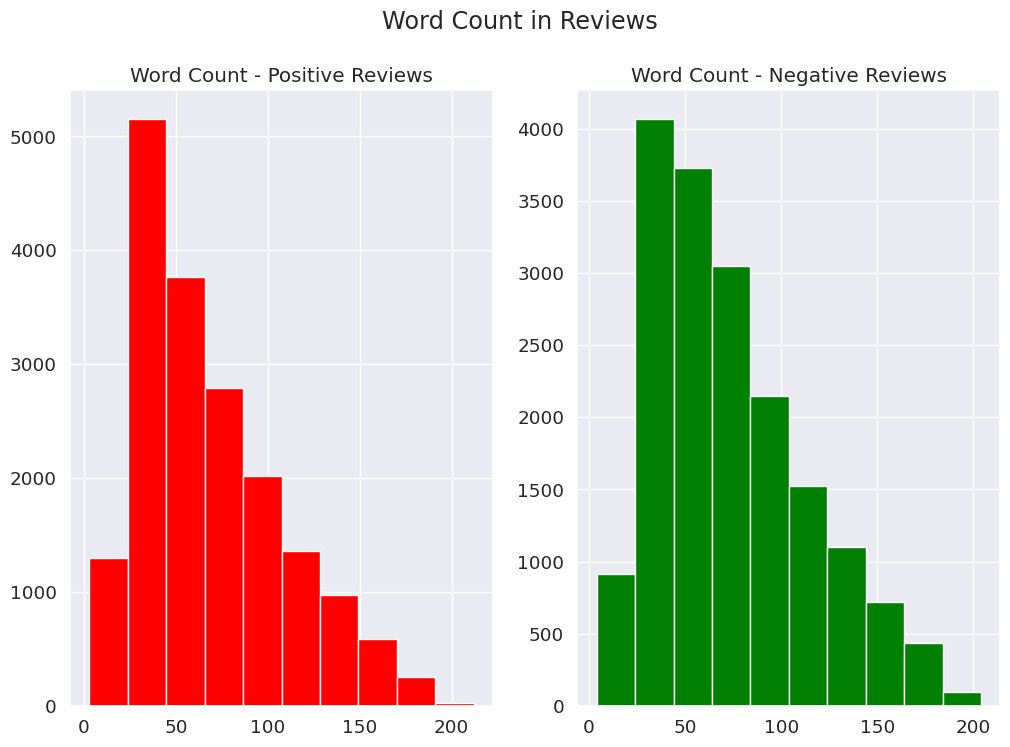

In [ ]:
# Plot review length (characters) for both sentiments
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
good_reviews_len = reviews_subset.filter(col("sentiment") == "positive").select(length(col("review"))).rdd.flatMap(lambda x: x).collect()
ax1.hist(good_reviews_len, color='red')
ax1.set_title('Text Length - Positive Reviews')

bad_reviews_len = reviews_subset.filter(col("sentiment") == "negative").select(length(col("review"))).rdd.flatMap(lambda x: x).collect()
ax2.hist(bad_reviews_len, color='green')
ax2.set_title('Text Length - Negative Reviews')

fig.suptitle('Characters in Reviews')
plt.show()

# Plot word count for both sentiments
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

# Word count for positive reviews
good_reviews_word_count = reviews_subset.filter(col("sentiment") == "positive") \
    .select(split(col("review"), " ").alias("words")) \
    .select(size(col("words")).alias("word_count")).rdd.flatMap(lambda x: x).collect()

ax1.hist(good_reviews_word_count, color='red')
ax1.set_title('Word Count - Positive Reviews')

# Word count for negative reviews
bad_reviews_word_count = reviews_subset.filter(col("sentiment") == "negative") \
    .select(split(col("review"), " ").alias("words")) \
    .select(size(col("words")).alias("word_count")).rdd.flatMap(lambda x: x).collect()

ax2.hist(bad_reviews_word_count, color='green')
ax2.set_title('Word Count - Negative Reviews')

fig.suptitle('Word Count in Reviews')
plt.show()

In [ ]:
# Function to generate a word corpus
def get_corpus(text_column):
    words = []
    for row in text_column.collect():
        words.extend(row[0].split())
    return words

corpus = get_corpus(reviews_subset.select("review"))
counter = Counter(corpus)
most_common_words = counter.most_common(10)
print("Most common words:", most_common_words)

# Function to get top n-grams
def get_top_text_ngrams(df, n, g):
    tokenizer = Tokenizer(inputCol="review", outputCol="words")
    tokenized = tokenizer.transform(df)

    ngram = NGram(n=g, inputCol="words", outputCol="ngrams")
    ngrams_df = ngram.transform(tokenized)

    cv = CountVectorizer(inputCol="ngrams", outputCol="features", vocabSize=10000)
    cv_model = cv.fit(ngrams_df)
    vectorized_df = cv_model.transform(ngrams_df)

    vocab = cv_model.vocabulary
    word_counts = vectorized_df.select("features").rdd.flatMap(lambda row: row[0].indices).collect()
    count_dict = Counter(word_counts)

    most_common = [(vocab[idx], count) for idx, count in count_dict.most_common(n)]
    return most_common

# Get top 20 unigrams
unigrams = get_top_text_ngrams(reviews_subset, 20, 1)
print("Top Unigrams:", unigrams)

# Get top 20 bigrams
bigrams = get_top_text_ngrams(reviews_subset, 20, 2)
print("Top Bigrams:", bigrams)

# Get top 20 trigrams
trigrams = get_top_text_ngrams(reviews_subset, 20, 3)
print("Top Trigrams:", trigrams)


Most common words: [('the', 108067), ('and', 65468), ('I', 61404), ('to', 60646), ('a', 60296), ('of', 49368), ('is', 42933), ('it', 35075), ('this', 34232), ('in', 27013)]
Top Unigrams: [('the', 31385), ('and', 27763), ('a', 27093), ('to', 25777), ('this', 25110), ('i', 24322), ('of', 23136), ('is', 22308), ('it', 21169), ('for', 17598), ('in', 17426), ('that', 14719), ('not', 13574), ('was', 13119), ('but', 12974), ('with', 12908), ('on', 12195), ('have', 11957), ('my', 11548), ('you', 10857)]
Top Bigrams: [('of the', 9408), ('in the', 6125), ('is a', 5770), ('this is', 5121), ('it is', 4781), ('and the', 4406), ('this book', 4401), ('i have', 4368), ('on the', 4066), ('to the', 3898), ('i was', 3747), ('it was', 3674), ('if you', 3667), ('for the', 3645), ('to be', 3487), ('and i', 3264), ('with the', 2967), ('for a', 2862), ('is the', 2720), ('one of', 2630)]
Top Trigrams: [('this is a', 1736), ('one of the', 1573), ('this book is', 1119), ('a lot of', 1012), ('i bought this', 912)

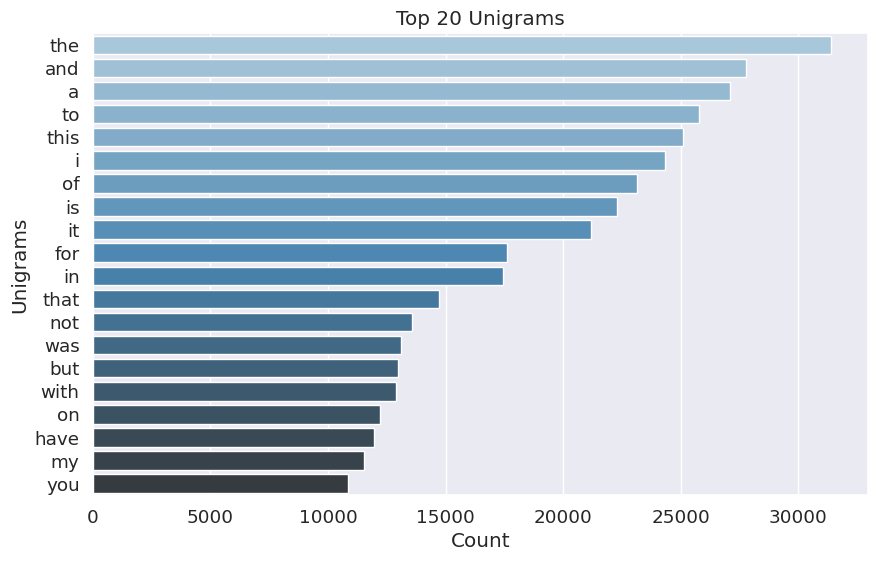

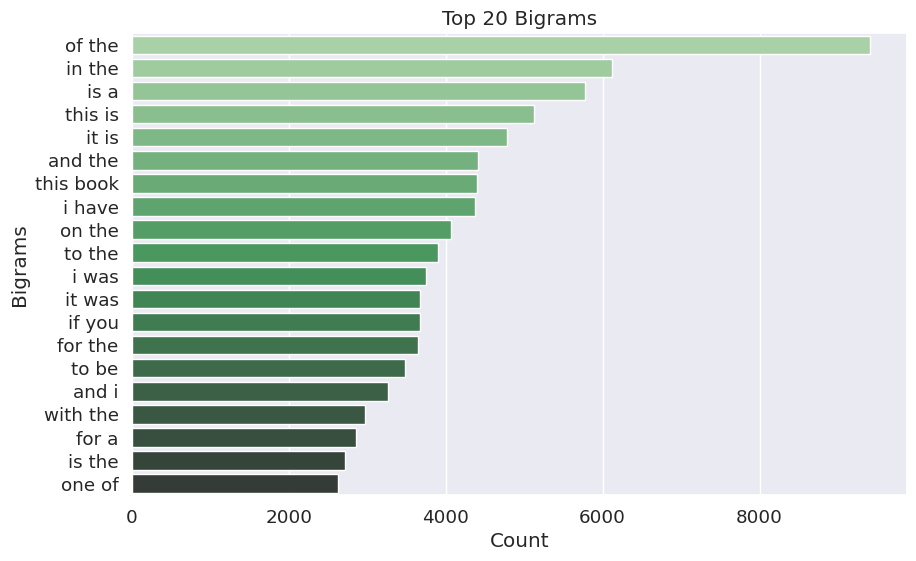

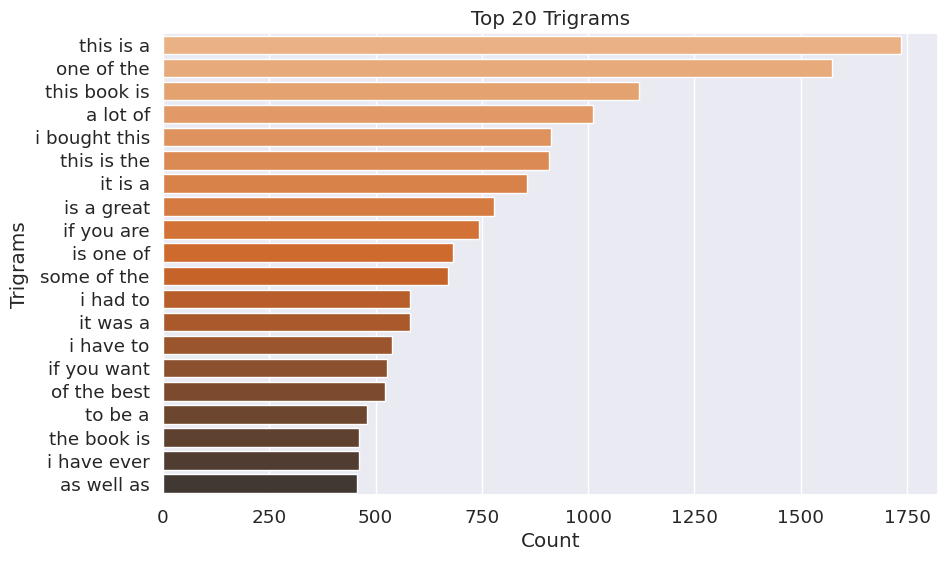

In [ ]:
import pandas as pd
def convert_to_dataframe(ngrams):
    return pd.DataFrame(ngrams, columns=['ngram', 'count'])

# Top Unigrams
unigrams_df = convert_to_dataframe(unigrams)
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='ngram', data=unigrams_df, palette='Blues_d')
plt.title('Top 20 Unigrams')
plt.xlabel('Count')
plt.ylabel('Unigrams')
plt.show()

# Top Bigrams
bigrams_df = convert_to_dataframe(bigrams)
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='ngram', data=bigrams_df, palette='Greens_d')
plt.title('Top 20 Bigrams')
plt.xlabel('Count')
plt.ylabel('Bigrams')
plt.show()

# Top Trigrams
trigrams_df = convert_to_dataframe(trigrams)
plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='ngram', data=trigrams_df, palette='Oranges_d')
plt.title('Top 20 Trigrams')
plt.xlabel('Count')
plt.ylabel('Trigrams')
plt.show()

In [ ]:
# SVM Model with LinearSVC
train_data, test_data = reviews_subset.randomSplit([0.8, 0.2], seed=42)

# Tokenization and vectorization pipeline
tokenizer = Tokenizer(inputCol="review", outputCol="words")
cv = CountVectorizer(inputCol="words", outputCol="features")

# SVC model definition
svc = LinearSVC(featuresCol="features", labelCol="label", maxIter=100)

# Pipeline construction
pipeline = Pipeline(stages=[tokenizer, cv, svc])

# Model training
model = pipeline.fit(train_data)

# Model evaluation
predictions = model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")

# Predicting on sample text
sample_text = ["I love this product", "This is terrible", "Very satisfied", "I will never buy again"]
sample_df = spark.createDataFrame([(t,) for t in sample_text], ["review"])
sample_predictions = model.transform(sample_df)
sample_predictions.select("review", "prediction").show()


Test Accuracy: 0.8363273453093812
+--------------------+----------+
|              review|prediction|
+--------------------+----------+
| I love this product|       0.0|
|    This is terrible|       1.0|
|      Very satisfied|       0.0|
|I will never buy ...|       1.0|
+--------------------+----------+



In [ ]:
from pyspark.ml.feature import Tokenizer, CountVectorizer, IDF, StringIndexer
# Tokenization and vectorization pipeline
tokenizer = Tokenizer(inputCol="review", outputCol="words")
cv = CountVectorizer(inputCol="words", outputCol="rawFeatures")

# Tính toán IDF
idf = IDF(inputCol="rawFeatures", outputCol="features")

# SVC model definition with adjusted parameters
svc = LinearSVC(featuresCol="features", labelCol="label", maxIter=200, regParam=0.01)

# Pipeline construction
pipeline = Pipeline(stages=[tokenizer, cv, idf, svc])

# Model training
model = pipeline.fit(train_data)

# Model evaluation
predictions = model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")

# Predicting on sample text
sample_text = ["I love this product", "This is terrible", "Very satisfied", "I will never buy again"]
sample_df = spark.createDataFrame([(t,) for t in sample_text], ["review"])
sample_predictions = model.transform(sample_df)
sample_predictions.select("review", "prediction").show()

Test Accuracy: 0.8541488451668092
+--------------------+----------+
|              review|prediction|
+--------------------+----------+
| I love this product|       0.0|
|    This is terrible|       1.0|
|      Very satisfied|       0.0|
|I will never buy ...|       0.0|
+--------------------+----------+



In [ ]:
from pyspark.ml import PipelineModel
model.save("/content/saved/model")
model_path = '/content/saved/model'
loaded_model = PipelineModel.load(model_path)


In [ ]:
sample_text = ["I love this product", "This is terrible", "Very satisfied", "I will never buy again"]
sample_df = spark.createDataFrame([(t,) for t in sample_text], ["review"])

# Sử dụng mô hình đã load để dự đoán
sample_predictions = loaded_model.transform(sample_df)
sample_predictions.select("review", "prediction").show()

+--------------------+----------+
|              review|prediction|
+--------------------+----------+
| I love this product|       0.0|
|    This is terrible|       1.0|
|      Very satisfied|       0.0|
|I will never buy ...|       0.0|
+--------------------+----------+

